In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import itertools
from collections import Counter
import json

nltk.download('brown')
nltk.download('stopwords')
stopwords = stopwords.words('english')

np.set_printoptions(suppress=True)

[nltk_data] Downloading package brown to /Users/r0g06z5/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/r0g06z5/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Latent Dirichlet Allocation (LDA)

**Topic Modelling**: The problem of Topic Modelling is that we are interested in finding topics that documents are based on, which can be later used for generating documents using them.

**LDA**: It is famously used for Topic Modelling.  We assume that any document is a multinomial distribution of a given number of yet unknown topics, and any topic is multinomial distribution of given vocabulary. Once we have estimated these distributions using Statistical Inference on given data (**maximizing the likelihood of distributions given observations**), we can build a probabilistic generative model to sample words from these distributions, hence generating documents. 

**Assumptions of LDA:**
1. LDA assumes a **Bag-of-Words (BOW)** model i.e. the order of words do not matter
2. Topic assignment is not exclusive i.e. as words can have different meanings under different contexts, a word can be assigned different topics under different contexts

We will divide the learning on LDA in two parts:
1. **Statistical Inference**: Given some reference data, we will estimate the topic distributions as per LDA algorithm with **Gibbs Sampling**
2. **Generative Model**: Having inferred the distributions, we will generate some documents and look at various applications of LDA

In this notebook, we will focus on the 1st part - estimating topic distributions and saving them for the second notebook.

In [2]:
# info

# number of iterations to run LDA
n_iters = 200

# number of documents to consider
n_docs = 10

# number of topics
n_topics = 5

# Dirichlet hyperparameters
eta = 1.5
alpha = 1.5
burnin_period_frac = 0.2

# seeding for reproducibility
seed = 42

In [3]:
np.random.seed(seed)
brown = nltk.corpus.brown
docs = np.random.choice(brown.fileids(), n_docs, replace=False)

print('Processing sentences..\n')
processed_docs = {}
for doc in docs:
    processed_sents = []
    sents = brown.sents(doc)
    for sent in sents:
        processed_sents.append([word.lower() for word in sent if word.isalnum() and word not in stopwords])
    processed_docs[doc] = processed_sents

processed_sents = list(itertools.chain(*list(processed_docs.values())))
final_tokens = list(set(itertools.chain(*processed_sents)))
n_tokens = len(final_tokens)

token2int = dict(zip(final_tokens, range(n_tokens)))
int2token = {v:k for k,v in token2int.items()}

doc2int = dict(zip(docs, range(n_docs)))
int2doc = {v:k for k,v in doc2int.items()}

print('Number of Documents:', n_docs) 
print('Number of Tokens:', n_tokens)    

Processing sentences..

Number of Documents: 10
Number of Tokens: 4447


### Gibbs Sampling

Gibbs Sampling is a form of **Markov Chain Monte Carlo (MCMC)**. It enables us to estimate the conditional probability of word token $z_{i}$ coming from document $d_{i}$, of being assigned topic $j$, **assuming all the other assignments are correct**. Essentially, we are interested in finding: 

$$
P\left(z_{i}=j \mid z_{-i}, w_{i}, d_{i}\right)
$$

Logically, it should depend on:
1. The likelihood of topic $j$ under document $d_{i}$
2. The likelihood of word $w_{i}$ under topic $j$

And so, the conditional probability is proportional to:
$$
P\left(z_{i}=j \mid z_{-i}, w_{i}, d_{i}\right) = K \frac{C_{w_{i} j}^{W T}+\eta}{\sum_{w=1}^{W} C_{w j}{ }^{W T}+W \eta} \frac{C_{d_{i} j}^{D T}+\alpha}{\sum_{t=1}^{T} C_{d j}{ }^{D T}+T \alpha}
$$

Points to note:
1. The proportional factor $K$ can be found with normalizing probabilities such that they sum to 1.
2. The individual likelihoods in the above equation represent **Dirichlet distribution** with $\eta$ and $\alpha$ as hyperparameters. Hence, the name Dirichlet in Latent Dirichlet Allocation.
3. A high $\alpha$ favours documents with equitable distribution of topics i.e. documents with balanced mixture of topics. Similarly, a low $\alpha$ favours documents with skewed distribution of topics. Similarly for $\eta$. 

### LDA algorithm

The algorithm starts with assigning each word to a random topic. 
For each iteration:
1. Compute word-topic (CWT) and document-topic (CDT) matrices
2. For each word token, sample a topic as per distribution, assuming the rest of topic assignments are correct

One pass on all words is called **Gibbs Sample**. 

Replace the topic assignment with newly generated topic assignment for the next iteration and repeat steps 1 and 2. 

#### Important points:
1. The initial few iterations of the algorithm is termed as **burn-in period** since the algorithm musn't have started converging. 
2. Since consecutive Gibbs samples can be correlated, we will estimate topic distributions from iterative topic assignments at fixed regular intervals.
3. Finally, we compute expectation of distributions to arrive at final topic distributions which we save and use to generate documents.

In [4]:
def get_topic_assignment(processed_docs, n_topics, seed):
    np.random.seed(seed)
    topic_assignment = {}
    for doc, sents in processed_docs.items():
        words = list(itertools.chain(*sents))
        topics_assigned = np.random.choice(range(n_topics), len(words), replace=True)
        topic_assignment[doc] = list(zip(words, topics_assigned))
    return topic_assignment

In [5]:
def get_CWT_matrix(topic_assignment):
    word_topics = topic_assignment.values()
    count_word_topics_dict = Counter(list(itertools.chain(*word_topics)))

    # words indices for CWT matrix
    CWT_words = np.array(list(count_word_topics_dict.keys()))[:, 0]
    CWT_words = list(map(lambda x: token2int[x], CWT_words))

    # topic indices for CWT matrix
    CWT_topics = list(map(int, np.array(list(count_word_topics_dict.keys()))[:, 1]))

    # counts for CWT matrix
    counts = list(count_word_topics_dict.values())

    # building CWT matrix
    CWT = np.zeros((n_tokens, n_topics), dtype='int')
    CWT[CWT_words, CWT_topics] = counts

    assert len(CWT_words) == len(CWT_topics) == len(counts)
    assert np.sum(CWT) == sum(counts)
    return CWT

In [6]:
def get_CDT_matrix(topic_assignment):
    CDT = np.zeros((n_docs, n_topics), dtype='int')

    for doc, word_topics in topic_assignment.items():
        count_topic_dict = Counter(list(map(int, np.array(word_topics)[:, 1])))
        topic_idxs = list(count_topic_dict.keys())
        topic_counts = list(count_topic_dict.values())
        CDT[doc2int[doc], topic_idxs] = topic_counts 
    return CDT

In [7]:
def get_sampled_topic(word_idx, doc_idx, CWT, CDT):
    dist = []
    for topic_idx in range(n_topics):
        pwt = (CWT[word_idx, topic_idx] -1 + eta) / (np.sum(CWT[:, topic_idx]) + n_tokens * eta)
        pdt = (CDT[doc_idx, topic_idx] -1 + alpha) /  (np.sum(CDT[doc_idx, :]) + n_topics * alpha)
        p = pwt * pdt
        dist.append(p)

    # normalize probabilities such that they sum to 1
    # resulting distribution is multinomial distribution
    dist = dist / sum(dist)
    outcome = np.random.multinomial(1, dist)
    sampled_topic_idx = np.where(outcome==1)[0][0]
    return sampled_topic_idx

In [8]:
def get_sampled_topics(doc_idx, word_topics, CWT, CDT):
    words = np.array(word_topics)[:, 0]
    sampled_topics = list(map(lambda word: get_sampled_topic(token2int[word], doc_idx, CWT, CDT), words))
    return list(zip(words, sampled_topics))

In [9]:
def get_Gibbs_sample(input_topic_assignment):
    # initialize input matrices
    CWT = get_CWT_matrix(input_topic_assignment)
    CDT = get_CDT_matrix(input_topic_assignment)

    # initialize output 
    new_topic_assignment = {}

    # iterate for all words
    docs = list(input_topic_assignment.keys())
    all_word_topics = list(input_topic_assignment.values())
    new_topic_assignment = dict(zip(docs, map(lambda doc, word_topics: \
                                                            get_sampled_topics(doc2int[doc], word_topics, CWT, CDT), docs, all_word_topics)))

    
    """
    ### loop form of iteration
    
    for doc, word_topics in input_topic_assignment.items():
        doc_idx = doc2int[doc]
        new_topic_assignment[doc] = []
        for word, _ in word_topics:
            word_idx = token2int[word]
            sampled_topic = get_sampled_topic(word_idx, doc_idx, CWT, CDT)
            new_topic_assignment[doc].append((word, sampled_topic))
    """   

    for doc in docs:
        assert len(new_topic_assignment[doc]) == len(input_topic_assignment[doc])
    return new_topic_assignment

In [10]:
def get_word_topic_distribution(final_tokens, n_topics, CWT):
    beta = {}
    for topic_idx in range(n_topics):
        dist = []
        for token in final_tokens:
            word_idx = token2int[token]
            p = (CWT[word_idx, topic_idx] + eta) / (np.sum(CWT[:, topic_idx]) + n_tokens * eta)
            dist.append(p)
        # normalize probabilities such that they sum to 1
        # resulting distribution is multinomial distribution
        dist = dist / sum(dist)
        beta[topic_idx] = dist
    return beta

def get_doc_topic_distribution(docs, n_topics, CDT):
    theta = {}
    for doc in docs:
        doc_idx = doc2int[doc]
        dist = []
        for topic_idx in range(n_topics):
            p = (CDT[doc_idx, topic_idx] + alpha) /  (np.sum(CDT[doc_idx, :]) + n_topics * alpha)
            dist.append(p)
        # normalize probabilities such that they sum to 1
        # resulting distribution is multinomial distribution
        dist = dist / sum(dist)
        theta[doc] = dist
    return theta

def get_distributions(topic_assignment):
    CWT = get_CWT_matrix(topic_assignment)
    CDT = get_CDT_matrix(topic_assignment) 
    beta = get_word_topic_distribution(final_tokens, n_topics, CWT)   
    theta = get_doc_topic_distribution(docs, n_topics, CDT)
    return beta, theta

#### Checking for convergence

We will check if the algorithm has reached stability or not with the following metrics: 
1. L2 Norm: Between consecutive topics assigned to all words
2. KL-Divergence: 
    1. Between consecutive word-topic distributions
    2. Between consecutive doc-topic distributions

We do not expect these metrics to monotonically decrease. However, we can infer if the algorithm has reached stability if these metrics hover around certain numbers.

In [11]:
def KL_divergence(p, q):
    return np.sum(p * np.log(p/q))

def sym_KL_divergence(p, q):
    return (KL_divergence(p, q) + KL_divergence(q, p)) / 2

def avg_KL_divergence(prev, new):
    avg_KL = 0
    count = 0
    for key in prev.keys():
        avg_KL += sym_KL_divergence(np.array(prev[key]), np.array(new[key]))
        count += 1
    return avg_KL / count
    
def get_L2_norm(prev_topic_assignment, new_topic_assignment):
    prev_topics = []
    for doc, word_topics in prev_topic_assignment.items():
        prev_topics += list(map(int, np.array(word_topics)[:, 1]))
    new_topics = []
    for doc, word_topics in new_topic_assignment.items():
        new_topics += list(map(int, np.array(word_topics)[:, 1]))
    assert len(prev_topics) == len(new_topics)
    return np.linalg.norm(np.array(prev_topics) - np.array(new_topics))

def evaluation(prev_topic_assignment, new_topic_assignment):
    # checking through L2 norm between topic assignments
    l2_norm = get_L2_norm(prev_topic_assignment, new_topic_assignment)

    # checking through KL divergence between distributions
    prev_beta, prev_theta = get_distributions(prev_topic_assignment)
    new_beta, new_theta = get_distributions(new_topic_assignment)
    beta_KL = avg_KL_divergence(prev_beta, new_beta)
    theta_KL = avg_KL_divergence(prev_theta, new_theta)
    return l2_norm, beta_KL, theta_KL

In [12]:
def plotting(L2_NORM, BETA_KL, THETA_KL):
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.plot(L2_NORM)
    plt.title('L2_NORM')

    plt.subplot(132)
    plt.plot(BETA_KL)
    plt.title('beta_KL')

    plt.subplot(133)
    plt.plot(THETA_KL)
    plt.title('theta_KL')
    plt.show()

In [13]:
def run_LDA(processed_docs, n_topics, burnin_period_frac, n_iters, seed):
    # burnin_period
    burnin_iters = int(burnin_period_frac * n_iters)

    # initial randomized topic assignment
    topic_assignment = get_topic_assignment(processed_docs, n_topics, seed)

    # store topic assignments at spaced intervals
    resulting_topic_assignments = {}

    L2_NORM = []
    BETA_KL = []
    THETA_KL = []
    for n_iter in range(n_iters):
        new_topic_assignment = get_Gibbs_sample(topic_assignment)
        l2_norm, beta_KL, theta_KL = evaluation(topic_assignment, new_topic_assignment)
        topic_assignment = new_topic_assignment

        # storing values for plotting
        L2_NORM.append(l2_norm)
        BETA_KL.append(beta_KL)
        THETA_KL.append(theta_KL)

        if (n_iter+1) % 10==0:
            print(f'Iteration {n_iter+1}: NORM: {l2_norm.round(3)} | beta_KL: {beta_KL} | theta_KL: {theta_KL}')

            if n_iter>burnin_iters:
                resulting_topic_assignments[n_iter] = topic_assignment

    return resulting_topic_assignments, L2_NORM, BETA_KL, THETA_KL

In [14]:
def get_final_distributions(resulting_topic_assignments):
    betas = []
    thetas = []
    for n_iter, topic_assignment in resulting_topic_assignments.items():
        beta, theta = get_distributions(topic_assignment)
        betas.append(beta)
        thetas.append(theta)

    # expected distributions
    avg_beta = dict(zip(range(n_topics), (sum(map(lambda x: np.array(list(x.values())), betas)) / len(betas)).tolist()))
    avg_theta = dict(zip(docs, (sum(map(lambda x: np.array(list(x.values())), thetas)) / len(thetas)).tolist()))
    return avg_beta, avg_theta

In [15]:
def save_distributions(avg_beta, avg_theta):
    with open('word_topic_distributions.json','w') as f:
        json.dump(avg_beta, f, indent=4)
    with open('doc_topic_distributions.json','w') as f:
        json.dump(avg_theta, f, indent=4)   

Running LDA for 200 iterations..
Iteration 10: NORM: 165.263 | beta_KL: 0.03430673456202178 | theta_KL: 0.016334140697051913
Iteration 20: NORM: 53.796 | beta_KL: 0.0036233309141511802 | theta_KL: 0.0019348248403270782
Iteration 30: NORM: 19.494 | beta_KL: 0.0003683782565807599 | theta_KL: 0.0004022501010912706
Iteration 40: NORM: 12.207 | beta_KL: 0.0001915598321577367 | theta_KL: 0.0003857092718688291
Iteration 50: NORM: 15.492 | beta_KL: 0.0002889977331101523 | theta_KL: 0.00047756795971837024
Iteration 60: NORM: 16.703 | beta_KL: 0.0003265404184636175 | theta_KL: 0.0005823011496518166
Iteration 70: NORM: 15.937 | beta_KL: 0.0002974178054125786 | theta_KL: 0.0005035598123195545
Iteration 80: NORM: 18.083 | beta_KL: 0.0002978985972832357 | theta_KL: 0.00047118642000198573
Iteration 90: NORM: 16.793 | beta_KL: 0.0002619331199120383 | theta_KL: 0.0003550764261530177
Iteration 100: NORM: 12.369 | beta_KL: 0.0002463410575230748 | theta_KL: 0.000304787551579541
Iteration 110: NORM: 14.56 

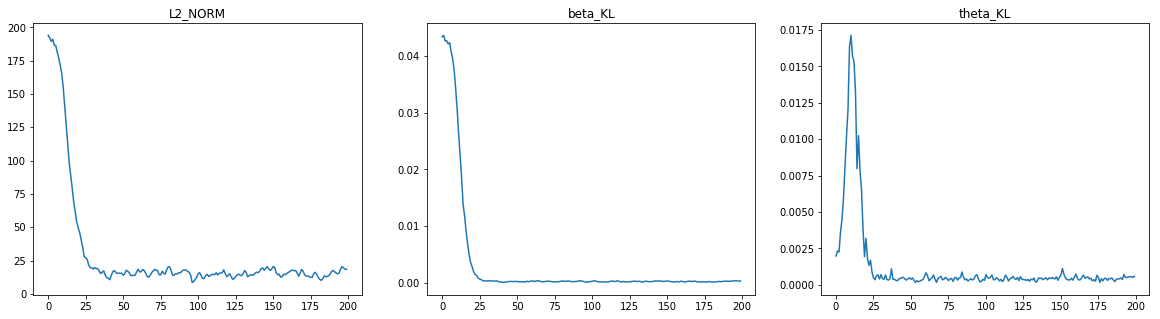

Taking expectation of distributions..
Saving results..
DONE!


In [16]:
print(f'Running LDA for {n_iters} iterations..')
resulting_topic_assignments, L2_NORM, BETA_KL, THETA_KL = run_LDA(processed_docs, n_topics, burnin_period_frac, n_iters, seed)

print('\nPlotting convergence plot..')
plotting(L2_NORM, BETA_KL, THETA_KL)

print('Taking expectation of distributions..')
avg_beta, avg_theta = get_final_distributions(resulting_topic_assignments)

print('Saving results..')
save_distributions(avg_beta, avg_theta)
print('DONE!')